In [1]:
import datetime
from datetime import datetime as dt
from dateutil import relativedelta
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
import os
# DataGenic module
from pymarketdata.datagenic import DataGenic

In [4]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from scipy import signal

In [6]:
# username = os.environ.get('DG_USERNAME')
# password = os.environ.get('DG_PASSWORD')
username = 'PIT018'
password = 'PIT018$1'

In [7]:
dg_url = "http://petro.datagenic.net:8080/"
dg = DataGenic(dg_url)
dg.connect(username, password)

print(f"DataGenic: {dg.version}")

DataGenic: Version 4.4.17.0.153, Built on 23-02-2022 05:43


In [8]:
from_date = datetime.date(2015, 1, 1)
to_date = datetime.date.today()

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

In [10]:
doba_model = 'model://PLATTS_RI/PLATTS.CRUDE.RI.AAXUV00'
nwe_lsfo_model = 'model://PI_OIL_PROD_HEA/PI.FO10.CCIFNWE.USD.MT.C/CURVE/M02/FINAL'
dtd_model = 'model://PI_OIL_CRU_NSEA/PI.BRENT.DTDMTHLY.USD.BBL.C/CURVE/M02/FINAL'
ice_brent_model = 'model://PI_OIL_CRU_ICE/PI.BRENT.ICESWAP.USD.BBL.C/CURVE/M02/FINAL'
dar_model = 'model://ARGUS_DCRDEAS/EU.OI.DCRDEAS.ARGUS.PA0005172.LONC.PROMPT'

In [11]:
dg_nwe_lsfo = dg.get_time_series(nwe_lsfo_model, from_date, to_date)
platts_doba_diff = dg.get_time_series(doba_model, from_date, to_date)
ice_brent = dg.get_time_series(ice_brent_model, from_date, to_date)
dtd_brent = dg.get_time_series(dtd_model, from_date, to_date)
dar = dg.get_time_series(dar_model, from_date, to_date)

In [12]:
rotts_stripping_margin = pd.read_excel('doba_playaround.xlsx', sheet_name='rotts_margin_python')
rotts_stripping_margin.set_index('date', inplace=True)
ag_stripping_margin = pd.read_excel('doba_playaround.xlsx', sheet_name='ag_margin_python')
ag_stripping_margin.set_index('date', inplace=True)
ag_stripping_margin['ulsfo_ag'] = ag_stripping_margin['ulsfo_ag']/6.33
ag_crack = ag_stripping_margin.merge(dtd_brent, how='left', left_index=True, right_index=True)
ag_crack['ulsfo_ag_crack'] = ag_crack['ulsfo_ag'] - ag_crack['PRICE']
ag_crack.drop(columns=['PRICE','ulsfo_ag'], inplace=True)

In [79]:
dar_diff = dar - dtd_brent
crack = dg_nwe_lsfo/6.33 - dtd_brent
dar_diff.rename(columns={'PRICE':'dar_diff'}, inplace=True)

In [209]:
dar_doba = platts_doba_diff.merge(dar_diff, right_index=True, left_index=True)
dar_doba.rename(columns={'PRICE':'doba_diff'}, inplace=True)
nwe_lsfo = dar_doba.merge(crack, left_index=True, right_index=True)
nwe_lsfo.rename(columns={'PRICE':'nwe_lsfo_crack'}, inplace=True)
df_to_dtd = nwe_lsfo.merge(rotts_stripping_margin, how='left', right_index=True, left_index=True)

In [212]:
dtd_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_to_dtd.values))
dtd_scaled.columns = df_to_dtd.columns
dtd_scaled.index = df_to_dtd.index

In [241]:
#ag pricing
ag = platts_doba_diff.merge(ag_crack, right_index=True, left_index=True)
ag.rename(columns={'PRICE':'doba_diff'}, inplace=True)

In [243]:
ag_scaled = pd.DataFrame(min_max_scaler.fit_transform(ag.values))
ag_scaled.columns = ag.columns
ag_scaled.index = ag.index

### ---------------------- ---------------------- data exploration  ---------------------- ----------------------

In [37]:
def plot_charts(df, title):
    f, axs = plt.subplots(2, len(df.columns.values)-1, figsize=(15,10))
    f.suptitle(title, fontsize=16, y=0.91)
    for i in range(len(df.columns.values)-1):
        sns.regplot(data=df, x=df[df.columns[0]], y=df[df.columns[i+1]], ax=axs[0,i])
        df.plot(kind='line', y=[df.columns.values[0],df.columns.values[i+1]], ax=axs[1,i])

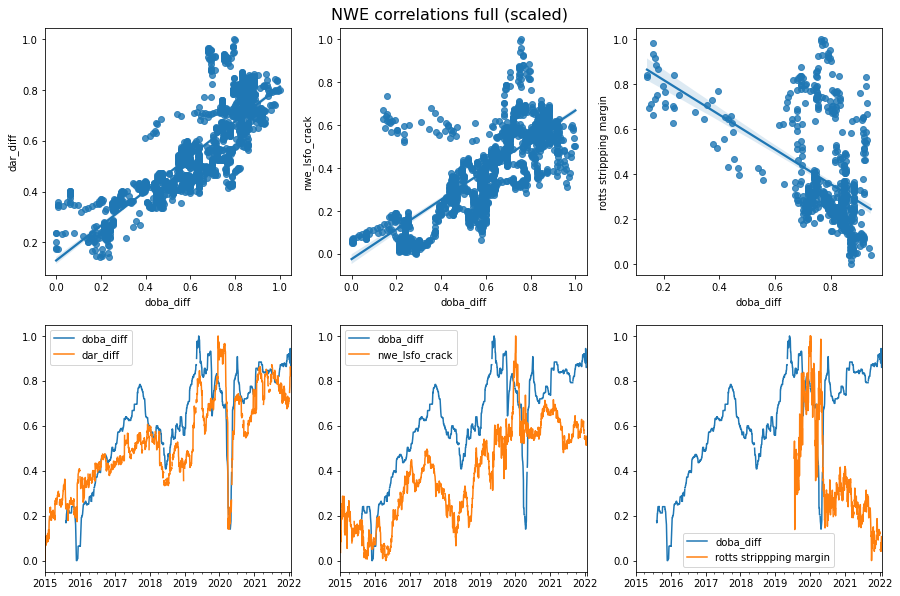

In [260]:
plot_charts(dtd_scaled, 'NWE correlations full (scaled)')

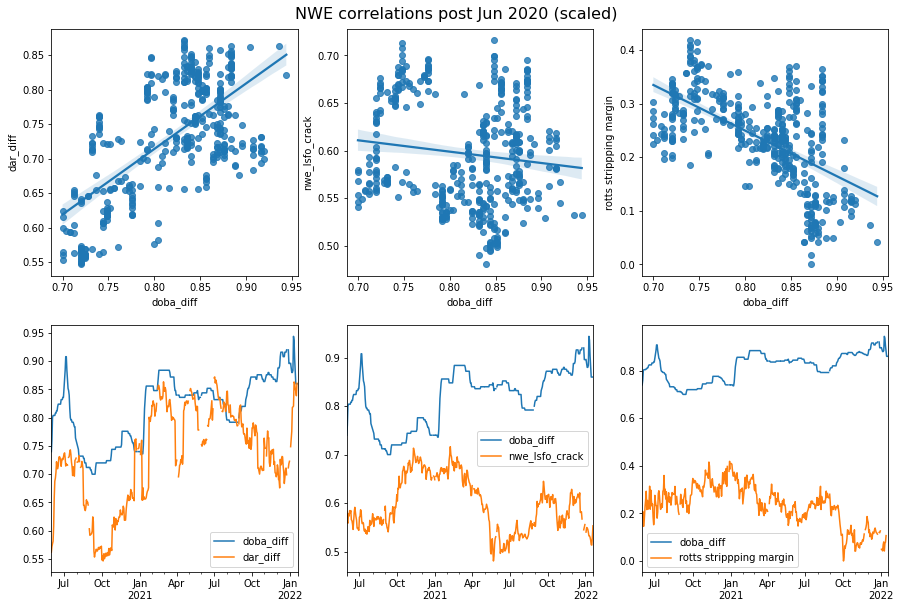

In [219]:
plot_charts(dtd_scaled['2020-06-01':], 'NWE correlations post Jun 2020 (scaled)')

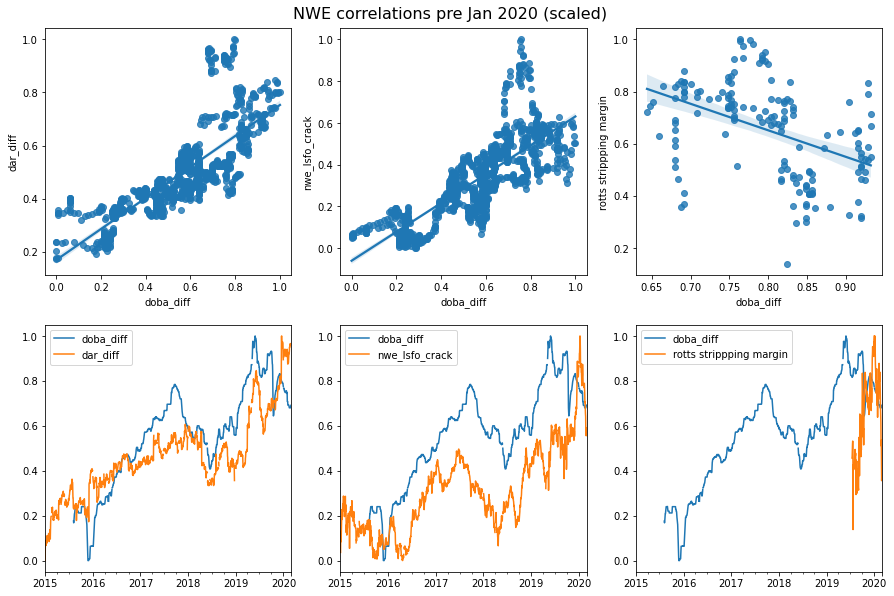

In [220]:
plot_charts(dtd_scaled[:'2020-03-01'], 'NWE correlations pre Jan 2020 (scaled)')

### ---------------------- ---------------------- AG  ---------------------- ----------------------

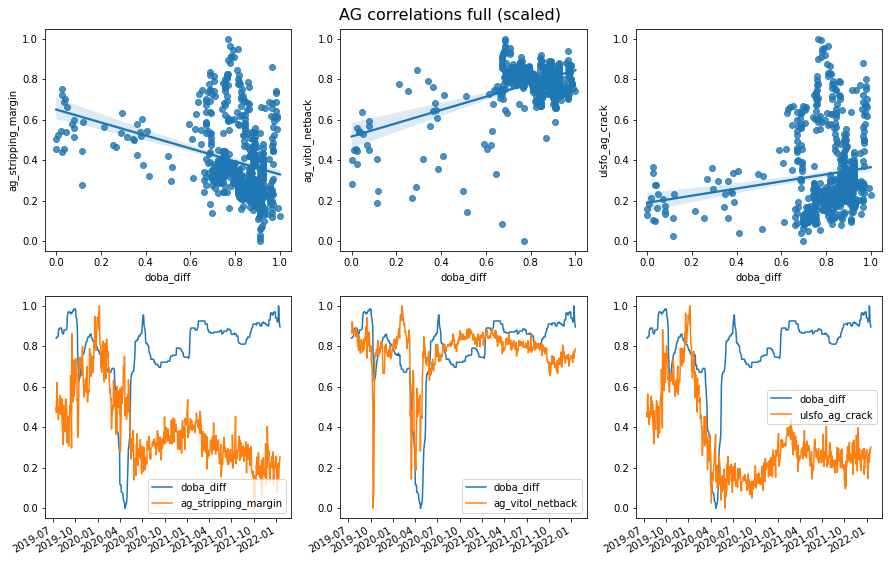

In [249]:
plot_charts(ag_scaled, 'AG correlations full (scaled)')

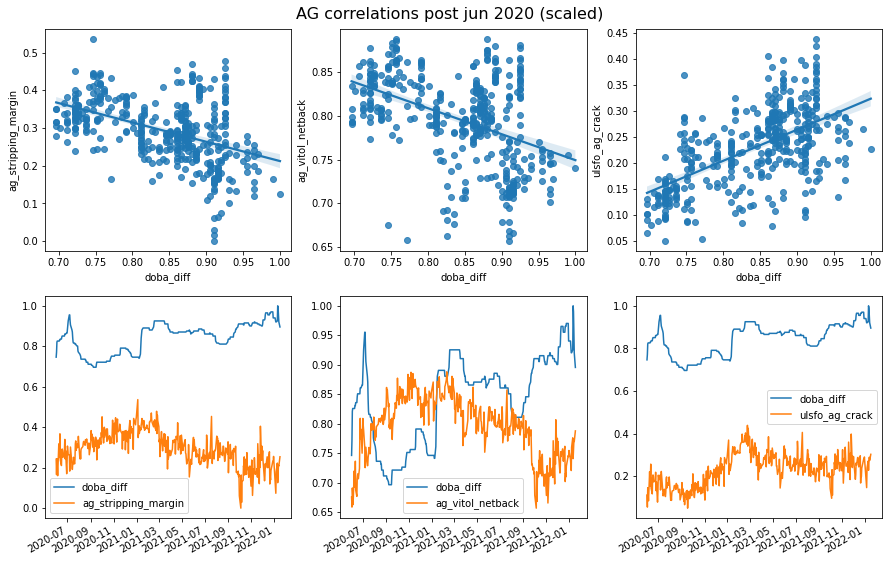

In [253]:
plot_charts(ag_scaled['2020-06-01':], 'AG correlations post jun 2020 (scaled)')

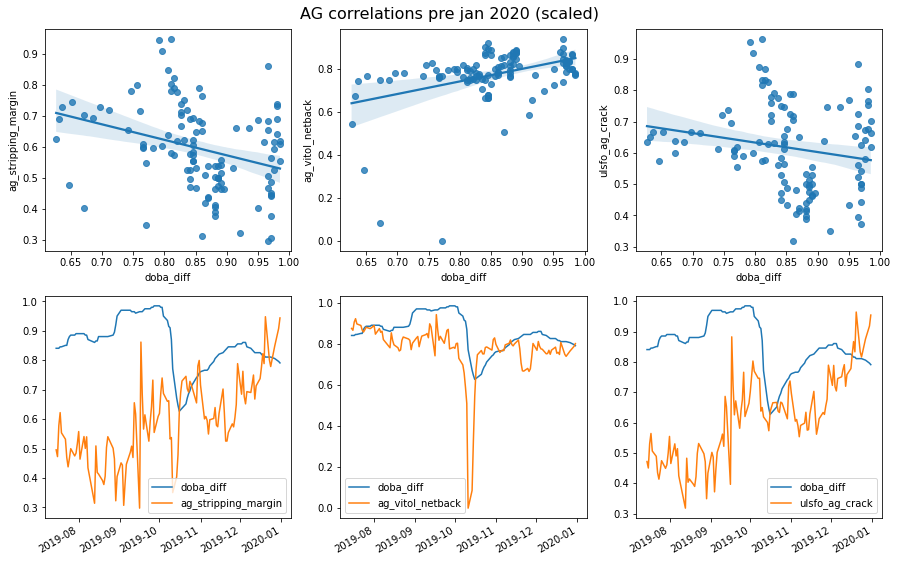

In [251]:
plot_charts(ag_scaled[:'2020-01-01'], 'AG correlations pre jan 2020 (scaled)')

### ---------------------- ---------------------- old functions  ---------------------- ----------------------

In [171]:
# def plot_charts(df, title):
#     f, axs = plt.subplots(2, 3, figsize=(15,10))
#     f.suptitle(title, fontsize=16, y=0.91)
#     sns.regplot(data=df, y=df[df.columns[0]], x=df[df.columns[1]], ax=axs[0,0])
#     df.plot(kind='line', y=[df.columns.values[0],df.columns.values[1]], ax=axs[1,0])
#     sns.regplot(data=df, y=df[df.columns[0]], x=df[df.columns[2]], ax=axs[0,1])
#     df.plot(kind='line', y=[df.columns.values[0],df.columns.values[2]], ax=axs[1,1])
#     sns.regplot(data=df, y=df[df.columns[0]], x=df[df.columns[3]], ax=axs[0,2])
#     df.plot(kind='line', y=[df.columns.values[0],df.columns.values[3]], ax=axs[1,2])

In [163]:
# f, axs = plt.subplots(2, 3, figsize=(15,10))
# f.suptitle('correlations full', fontsize=16)
# sns.regplot(data=df_to_dtd, y='doba_diff', x='dar_diff', ax=axs[0,0])
# df_to_dtd.plot(kind='line', y=['doba_diff','dar_diff'], ax=axs[1,0])
# sns.regplot(data=df_to_dtd, y='doba_diff', x='nwe_lsfo_crack', ax=axs[0,1])
# df_to_dtd.plot(kind='line', y=['doba_diff','nwe_lsfo_crack'], ax=axs[1,1])
# sns.regplot(data=df_to_dtd, y='doba_diff', x='nwe_lsfo_crack', ax=axs[0,2])
# df_to_dtd.plot(kind='line', y=['doba_diff','nwe_lsfo_crack'], ax=axs[1,2])

In [ ]:
# test regression pre 2020 and post 2020
# email resutls to adam

### ---------------------- ---------------------- doba loaded to platts doba  ---------------------- ----------------------

In [41]:
def transform_scale(df):
    scaled = pd.DataFrame(min_max_scaler.fit_transform(df.values))
    scaled.columns = df.columns
    scaled.index = df.index
    return scaled

In [17]:
ag_crack.head()

ag_stripping_margin  ag_vitol_netback  ulsfo_ag_crack
date                                                             
2019-07-15             7.895025              0.37       18.697947
2019-07-16             7.433465             -0.12       18.104361
2019-07-17             9.544753              2.07       20.317290
2019-07-18            10.435115              2.98       21.270955
2019-07-19             9.056623              1.57       19.662365

In [55]:
ice_brent_m1_model = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M01'
ice_brent_m2_model = 'model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M03'

brent_m1 = dg.get_time_series(ice_brent_m1_model, from_date, to_date)
brent_m2 = dg.get_time_series(ice_brent_m2_model, from_date, to_date)
dtd_m1_m2 = brent_m1 - brent_m2
dtd_m1_m2.reset_index(inplace=True)
dtd_m1_m2.rename(columns={'index':'date','PRICE':'brent_structure'}, inplace=True)

In [56]:
platts_doba_diff = dg.get_time_series(doba_model, from_date, to_date)
platts_doba_diff.reset_index(inplace=True)
platts_doba_diff.rename(columns={'index':'date', 'PRICE':'platts_doba_assessment'}, inplace=True)

In [57]:
doba_loaded = pd.read_excel('doba_playaround.xlsx', sheet_name='Prog')
doba_loaded['date'] = pd.to_datetime(doba_loaded['inferred_pricing_date'].astype(str))
doba_loaded.drop(columns=['inferred_pricing_date', 'load_date'], inplace=True)
# doba_loaded.set_index('date', inplace=True)

In [22]:
# doba_loaded[doba_loaded['date'].isin(platts_doba_diff['date'])]

In [23]:
len(doba_loaded)

338

<AxesSubplot:>

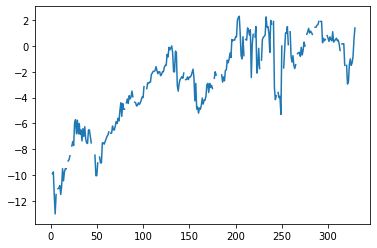

In [24]:
doba_loaded['Tracking (based on load date)'].plot(kind='line')

In [58]:
combined = platts_doba_diff.merge(doba_loaded, how='left', on='date')
combined['Tracking (based on load date)'] = combined['Tracking (based on load date)'].interpolate()

In [26]:
# tracking = combined[combined['Tracking (based on load date)'].notnull()]

<AxesSubplot:xlabel='date'>

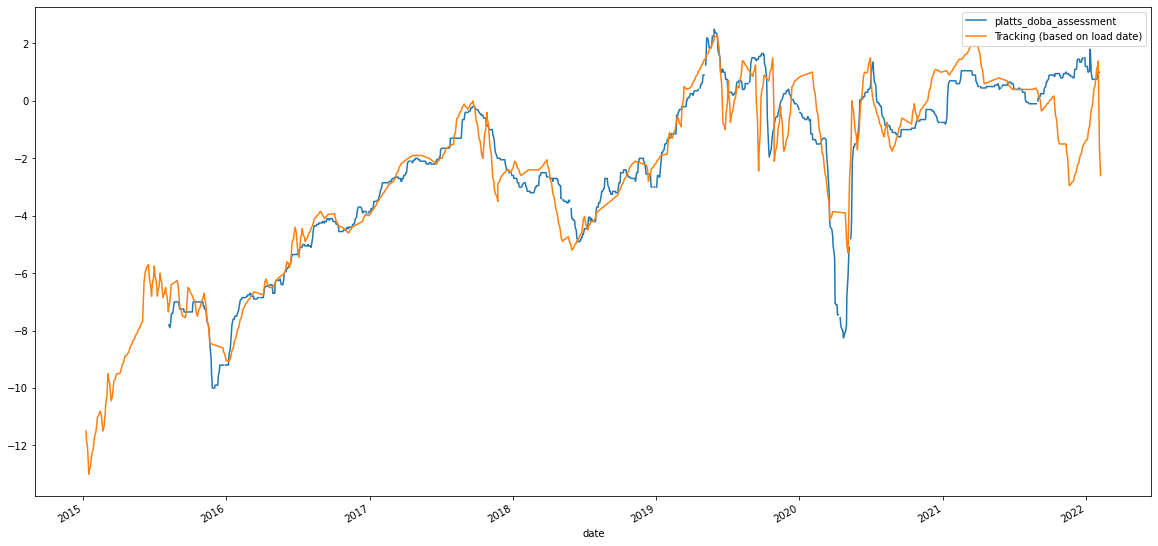

In [64]:
combined.set_index('date').plot(kind='line', figsize=(20,10))

In [65]:
doba_brent = combined.merge(dtd_m1_m2, how='left', on='date')
doba_brent.set_index('date', inplace=True)

In [80]:
crack.head()

PRICE
2015-01-01        NaN
2015-01-02 -12.459984
2015-01-05 -10.675930
2015-01-06 -10.096364
2015-01-07 -11.277703

In [129]:
doba_ag = doba_brent.merge(ag_crack, how='left', left_index=True, right_index=True)
doba_full = doba_ag.merge(crack, how='left', left_index=True, right_index=True)
doba_full.rename(columns={'PRICE':'nwe_lsfo_crack'}, inplace=True)
doba_scaled = transform_scale(doba_full)

In [130]:
doba_smooth = doba_scaled.rolling(3).mean().interpolate()

<AxesSubplot:>

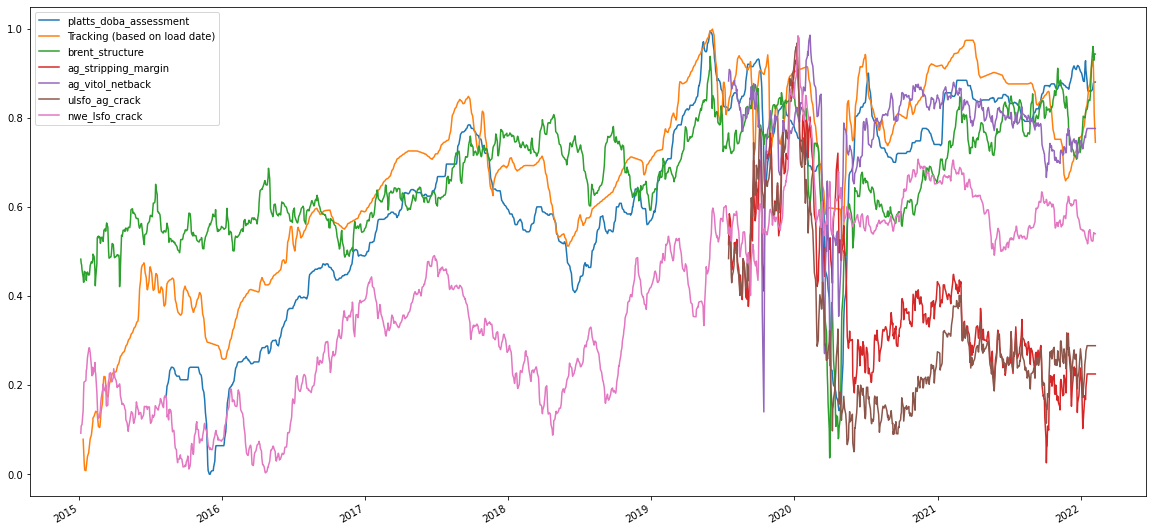

In [131]:
doba_smooth.plot(kind='line', figsize=(20,10))

In [132]:
# doba_brent_chart=doba_ag[['Tracking (based on load date)', 'platts_doba_assessment', 'brent_structure', 'ulsfo_ag_crack']].copy()
doba_brent_chart=doba_smooth[['Tracking (based on load date)', 'ag_vitol_netback', 'nwe_lsfo_crack', 'ulsfo_ag_crack']].copy()

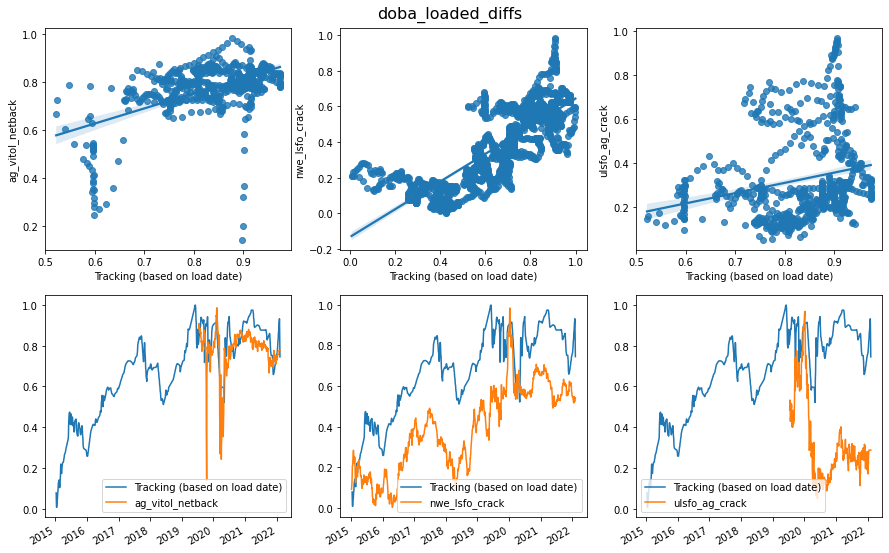

In [134]:
plot_charts(doba_brent_chart, 'doba_loaded_diffs')

In [144]:
doba_fo = doba_full[['Tracking (based on load date)', 'ag_vitol_netback', 'nwe_lsfo_crack', 'ulsfo_ag_crack']].copy()
doba_smooth_2021 = transform_scale(doba_fo['2021-01-01':]).rolling(3).mean().interpolate()

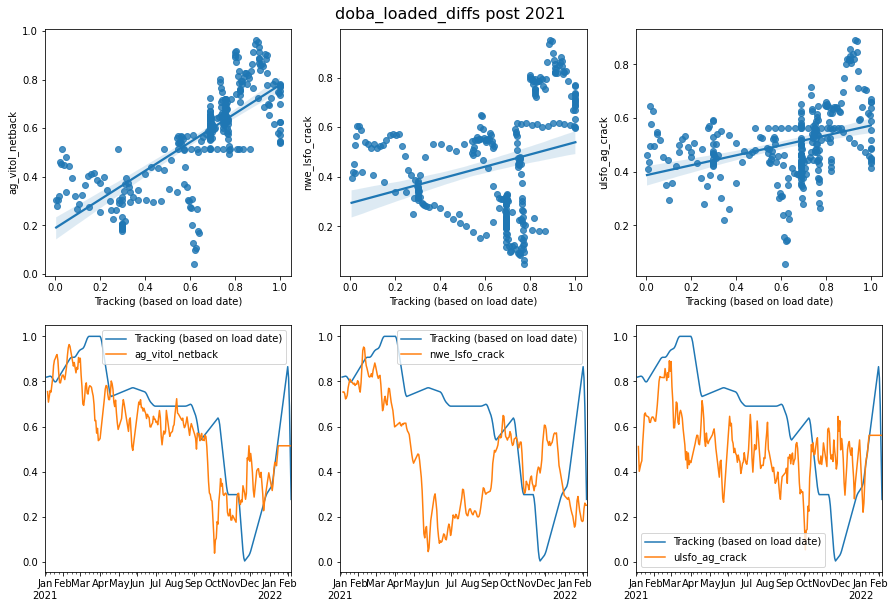

In [147]:
plot_charts(doba_smooth_2021, 'doba_loaded_diffs post 2021')

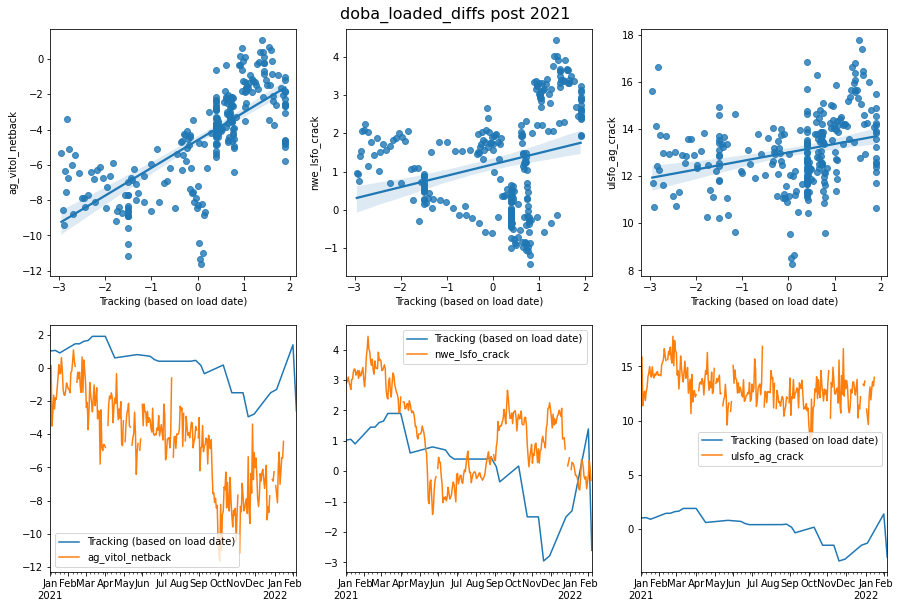

In [148]:
plot_charts(doba_fo['2021-01-01':], 'doba_loaded_diffs post 2021')

In [206]:
doba_brent['spread'] = doba_brent['platts_doba_assessment'] - doba_brent['Tracking (based on load date)']
doba_brent['axis'] = 0

Text(0.5, 1.0, 'spread platts doba vs traded diffs')

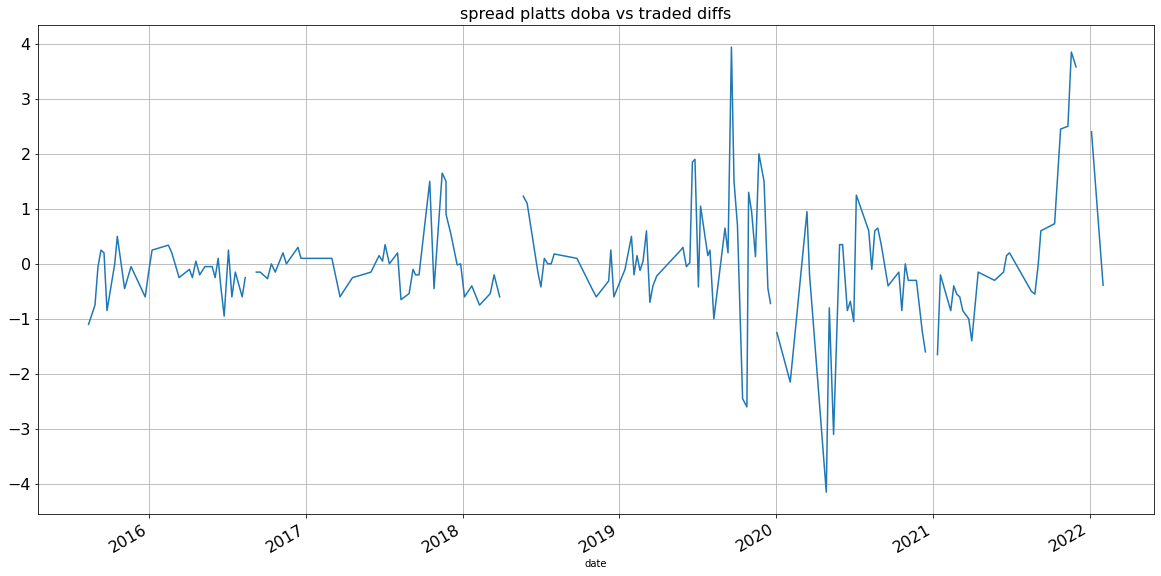

In [212]:
ax = doba_brent['spread'].plot(kind='line', figsize=(20,10), title='spread platts doba vs traded diffs', grid=True, fontsize=16)
ax.set_title(label='spread platts doba vs traded diffs', fontsize=16)

### ---------------------- ---------------------- Doba term to platts doba  ---------------------- ----------------------

In [12]:
doba_term = pd.read_excel('doba/CNPC Historical Doba deals with BL date.xlsx', sheet_name='doba_term')
doba_term_diff = doba_term[['B/L DATE','day1','day2','day3','day4','day5', 'Diff']].copy()

In [13]:
doba_melt = doba_term_diff.melt(id_vars=['B/L DATE', 'Diff'], value_name='pricing date', var_name='pricing day')
doba_melt.sort_values(['B/L DATE','pricing day'], inplace=True)

In [14]:
doba_term_platts = doba_melt.merge(platts_doba_diff,how='left', left_on='pricing date', right_index=True)

In [15]:
doba_av = doba_term_platts.groupby('B/L DATE').mean()
doba_av.rename(columns={'PRICE':'PLATTS 5 day average', 'Diff':'Term diff'}, inplace=True)

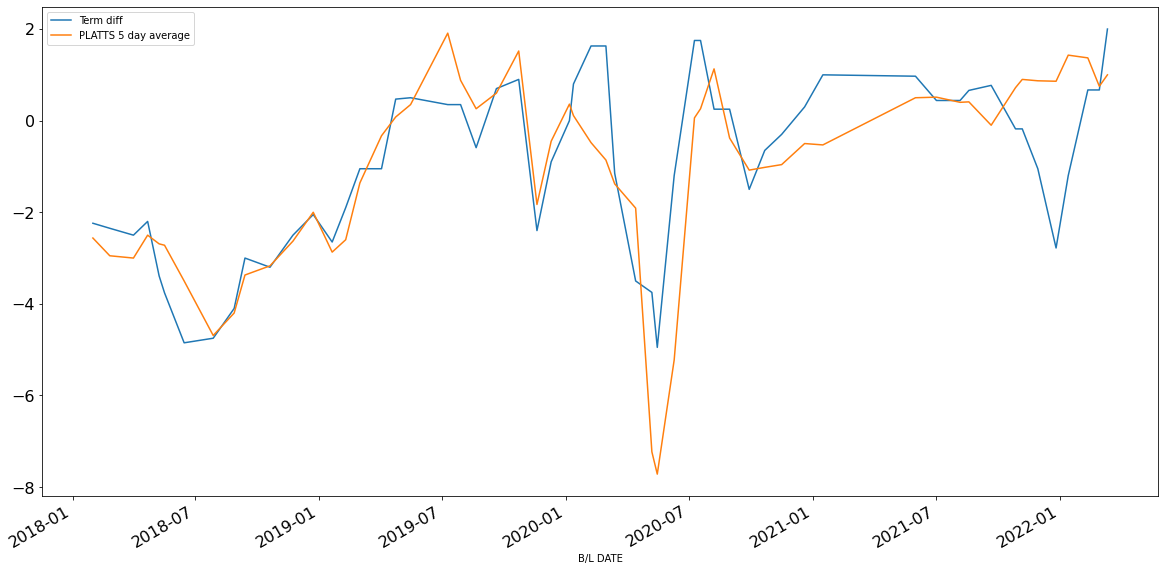

In [19]:
doba_av.plot(kind='line', figsize=(20,10), fontsize=16)
plt.savefig('doba term diff vs platts quotes 5 day average')

In [16]:
doba_av['spread'] = doba_av['PLATTS 5 day average']-doba_av['Term diff']

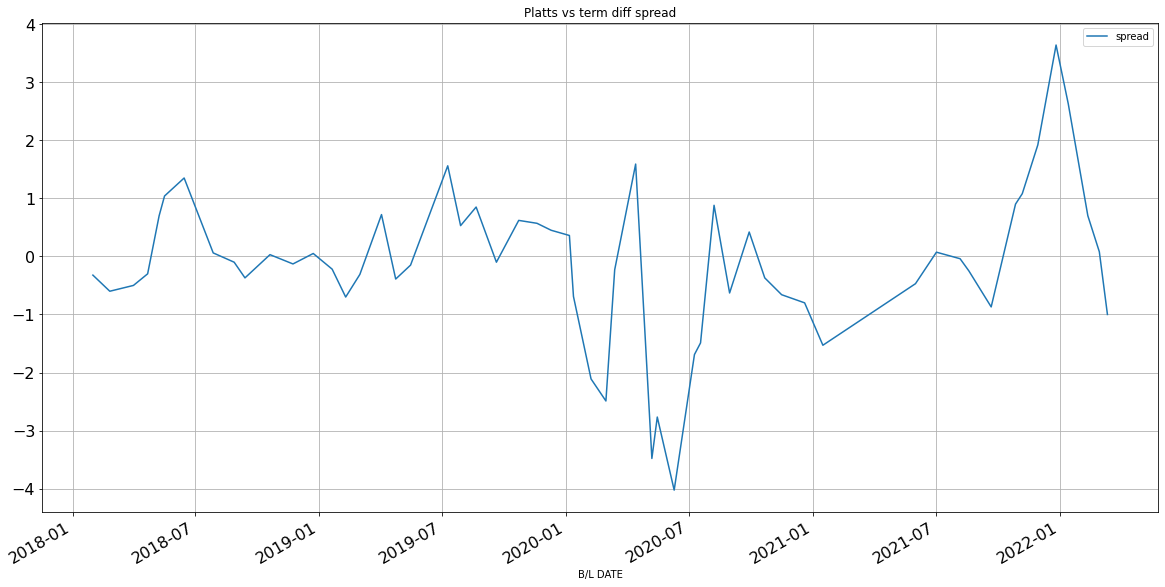

In [22]:
doba_av.plot(kind='line', y='spread', figsize=(20,10), grid=True, fontsize=16, title='Platts vs term diff spread')
plt.savefig('spread of term diff vs platts quotes')

In [19]:
writer = pd.ExcelWriter('doba/doba term diff vs platts quotes.xlsx', engine='xlsxwriter')
doba_term_platts.to_excel(writer, sheet_name='term diff vs 5 platts quotes', index=False)
doba_av.to_excel(writer, sheet_name='av. 5 quotes vs term diff', index=False)
writer.save()

In [ ]:
doba_term_platts.scatter(x='PRICE', y=)

### ---------------------- ---------------------- WTI  ---------------------- ----------------------

In [ ]:
wti_m1_model = 'model://ICE_WTI/EU.OIL.WTI.ICE.WTI.FUT.M01/SETTLE/ALL'
wti_dec22_model = 'model://ICE_WTI_1630/EU.OIL.WTI.ICE.WTI.FUT.2022M12/PRICE/ALL'

In [ ]:
wti_m1 = dg.get_time_series(wti_m1_model, start,end)
wti_dec22 = dg.get_time_series(wti_dec22_model, start,end)
wti_m1.rename(columns={'PRICE':'wti_m1'}, inplace=True)
wti_dec22.rename(columns={'PRICE':'wti_dec22'}, inplace=True)

In [ ]:
wti = wti_m1.merge(wti_dec22, right_index=True, left_index=True)
wti['spread'] = wti['wti_m1'] - wti['wti_dec22']

In [ ]:
wti.to_excel('wti.xlsx', sheet_name='wti')

In [59]:
# y = doba_loaded['inferred_pricing_date'].apply(lambda x: dt.strftime(x,'%Y-%m-%d'))

In [75]:
# y = [dt.strptime(x, '%Y-%m-%d-&H-%M-%S') for x in doba_loaded['inferred_pricing_date'].astype(str)]

In [54]:
dt.strftime(doba_loaded['inferred_pricing_date'][2], '%Y-%m-%d')

'2014-12-24'